# Clustering of VGG features

In [1]:
# for loading/processing the images  
from keras.preprocessing.image import load_img 
from keras.preprocessing.image import img_to_array 
from keras.applications.vgg16 import preprocess_input 

# models 
from keras.applications.vgg16 import VGG16 
from keras.models import Model

# clustering and dimension reduction
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# for everything else
import os
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import pandas as pd
import pickle
from skimage import io

from find_maxima import find_maxima
import tifffile
import glob

from PIL import Image
import sys
sys.path.append('../src')
from convert_ROI_to_cell_volumes import *

from scipy import ndimage
# for loading/processing the images  
from keras.preprocessing.image import load_img 
from keras.preprocessing.image import img_to_array 
from keras.applications.vgg16 import preprocess_input 

# models 
from keras.applications.vgg16 import VGG16 
from keras.models import Model
from sklearn.manifold import TSNE

         
            
model = VGG16()
model = Model(inputs = model.inputs, outputs = model.layers[-2].output)

Using TensorFlow backend.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:22: FutureWarning: The linear_assignment_ module is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


In [ ]:
path = '/Users/dominicwaithe/Desktop/cell_images/'
# change the working directory to the path where the images are located
os.chdir(path)

# this list holds all the image filename
flowers = []

# creates a ScandirIterator aliased as files
with os.scandir(path) as files:
  # loops through each file in the directory
    for file in files:
        if file.name.endswith('.png'):
          # adds only the image files to the flowers list
            flowers.append(file.name)


In [ ]:
# load the image as a 224x224 array
img = load_img(flowers[0], target_size=(224,224))
# convert from 'PIL.Image.Image' to numpy array
img = np.array(img)

print(img.shape)


In [ ]:

num_of_cells = 4000
flowers_sub = flowers[0:num_of_cells]

   

def extract_features(file, model):
    # load the image as a 224x224 array
    img = load_img(file, target_size=(224,224))
    # convert from 'PIL.Image.Image' to numpy array
    img = np.array(img)
    # reshape the data for the model reshape(num_of_samples, dim 1, dim 2, channels)
    reshaped_img = img.reshape(1,224,224,3) 
    # prepare image for model
    imgx = preprocess_input(reshaped_img)
    # get the feature vector
    features = model.predict(imgx, use_multiprocessing=True)
    return features
   
data = {}
p = '/Users/dominicwaithe/Desktop/cell_images/'

# lop through each image in the dataset
for flower in flowers_sub:
    # try to extract the features and update the dictionary
    #try:
        feat = extract_features(flower,model)
        data[flower] = feat
    # if something fails, save the extracted features as a pickle file (optional)
    #except:
    #    with open(p,'wb') as file:
    #        pickle.dump(data,file)
          
 
# get a list of the filenames
filenames = np.array(list(data.keys()))

# get a list of just the features
feat = np.array(list(data.values()))

# reshape so that there are 210 samples of 4096 vectors
feat = feat.reshape(-1,4096)

# get the unique labels (from the flower_labels.csv)
#df = pd.read_csv('flower_labels.csv')
#label = df['label'].tolist()


# reduce the amount of dimensions in the feature vector
pca = PCA(n_components=10, random_state=22)
pca.fit(feat)


#_TSNE = TSNE(n_components=2)
#x = _TSNE.fit_transform(feat)

x = pca.transform(feat)

# cluster feature vectors
kmeans = KMeans(n_clusters=4,n_jobs=-1, random_state=22)
kmeans.fit(x)

# holds the cluster id and the images { id: [images] }
groups = {}
for file, cluster in zip(filenames,kmeans.labels_):
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(file)
    else:
        groups[cluster].append(file)

# function that lets you view a cluster (based on identifier)        
def view_cluster(cluster):
    plt.figure(figsize = (25,25));
    # gets the list of filenames for a cluster
    files = groups[cluster]
    # only allow up to 30 images to be shown at a time
    if len(files) > 30:
        print(f"Clipping cluster size from {len(files)} to 30")
        files = files[:29]
    # plot each image in the cluster
    for index, file in enumerate(files):
        plt.subplot(10,10,index+1);
        img = load_img(file)
        img = np.array(img)
        plt.imshow(img)
        plt.axis('off')
        

        

In [ ]:
view_cluster(0)

In [ ]:
view_cluster(1)

In [ ]:
view_cluster(2)

In [ ]:
view_cluster(3)

In [ ]:
print(x.shape)
labels = kmeans.labels_
bint = labels==0
plt.plot(x[bint,0],x[bint,1],'x')
bint = labels==1
plt.plot(x[bint,0],x[bint,1],'bo')
bint = labels==2
plt.plot(x[bint,0],x[bint,1],'ko')
bint = labels==3
plt.plot(x[bint,0],x[bint,1],'+')
#bint = labels==4
#plt.plot(x[bint,0],x[bint,1],'go')

In [ ]:
ntol =30
def find_local_maxima_np(img_data):
    #This is the numpy/scipy version of the above function (find local maxima).
    #Its a bit faster, and more compact code.
    
    #Filter data with maximum filter to find maximum filter response in each neighbourhood
    max_out = ndimage.filters.maximum_filter(img_data,size=3)
    #Find local maxima.
    local_max = np.zeros((img_data.shape))
    local_max[max_out == img_data] = 1
    local_max[img_data == np.min(img_data)] = 0
    return local_max.astype(np.bool)

group_count = []
for i in range(0,5):
    count = []
    for cell in range(groups[i].__len__()):
        file = groups[i][cell]
        img = load_img(file)
        img_data = np.array(img).astype(np.float64)[:,:,0]
        #img_data = ndimage.gaussian_filter(img_data,4)
        #Finds the local maxima using maximum filter.
        local_max = find_local_maxima_np(img_data)
        y1,x1,out = find_maxima(img_data,local_max.astype(np.uint8),ntol)
        count.append(y1.__len__())
        
    group_count.append(np.average(count))
print(group_count)  

In [ ]:
# function that lets you view a cluster (based on identifier)        
def view_cluster(cluster):
    plt.figure(figsize = (25,25));
    # gets the list of filenames for a cluster
    files = groups[cluster]
    # only allow up to 30 images to be shown at a time
    if len(files) > 100:
        print(f"Clipping cluster size from {len(files)} to 30")
        files = files[:99]
    # plot each image in the cluster
    for index, file in enumerate(files):
        plt.subplot(10,10,index+1);
        img = load_img(file)
        img = np.array(img)
        plt.imshow(img)
        plt.axis('off')

### TSNE and Kmeans prediction of images.

In [ ]:

outpaths = []
#outpaths.append("/Users/dominicwaithe/Desktop/out02/")
#outpaths.append("/Users/dominicwaithe/Desktop/out03/")
#outpaths.append("/Users/dominicwaithe/Desktop/out04/")
#outpaths.append("/Users/dominicwaithe/Desktop/out05/")
#outpaths.append("/Users/dominicwaithe/Desktop/out06/")
#outpaths.append("/Users/dominicwaithe/Desktop/out07/")
#outpaths.append("/Users/dominicwaithe/Desktop/out08/")
#outpaths.append("/Users/dominicwaithe/Desktop/out09/")
#outpaths.append("/Users/dominicwaithe/Desktop/out10/")
#outpaths.append("/Users/dominicwaithe/Desktop/out11/")
#outpaths.append("/Users/dominicwaithe/Desktop/out12/")
#outpaths.append("/Users/dominicwaithe/Desktop/out13/")
#outpaths.append("/Users/dominicwaithe/Desktop/out14/")
#outpaths.append("/Users/dominicwaithe/Desktop/out15/")
#outpaths.append("/Users/dominicwaithe/Desktop/out16/")
outpaths.append("/Users/dominicwaithe/Desktop/relabel05out/")
outpaths.append("/Users/dominicwaithe/Desktop/relabel06out/")
outpaths.append("/Users/dominicwaithe/Desktop/relabel07out/")
outpaths.append("/Users/dominicwaithe/Desktop/relabel08out/")
outpaths.append("/Users/dominicwaithe/Desktop/relabel09out/")
outpaths.append("/Users/dominicwaithe/Desktop/relabel10out/")
outpaths.append("/Users/dominicwaithe/Desktop/relabel11out/")
outpaths.append("/Users/dominicwaithe/Desktop/relabel12out/")
outpaths.append("/Users/dominicwaithe/Desktop/relabel13out/")
outpaths.append("/Users/dominicwaithe/Desktop/relabel14out/")
outpaths.append("/Users/dominicwaithe/Desktop/relabel15out/")
outpaths.append("/Users/dominicwaithe/Desktop/relabel16out/")

In [ ]:
outpaths = ['/Users/dominicwaithe/Desktop/special/']
img_path = '/Users/dominicwaithe/Desktop/special/'
pca = pickle.load(open( "/Users/dominicwaithe/Desktop/cell_images/pca.pickle", "rb" ))
kmeans = pickle.load(open( "/Users/dominicwaithe/Desktop/cell_images/kmeans.pickle", "rb" ))
channel = 0
cell_data = []

imgnum = 0
xs = []
#flowers_sub.sort()
for path in outpaths:
    data,roi_array = collect_info(path,channel,'raw')
    store_cell_feats = []
    for cell in range(0,data.__len__()):
        
        img_vol = data[cell]
        cell_shape = img_vol.__len__()
        raw_img = img_vol[cell_shape//2]
        nimg = normalise_for_8bit(raw_img)
        io.imsave(img_path+"/temp.png", nimg)  
        
        img = load_img(img_path+"/temp.png", target_size=(224,224))
        img = np.array(img)
        
        
        reshaped_img = img.reshape(1,224,224,3) 
        # prepare image for model
        imgx = preprocess_input(reshaped_img)
        # get the feature vector
        features = model.predict(imgx, use_multiprocessing=True)
        store_cell_feats.append(features)

    feat = np.array(list(store_cell_feats))
    feat = feat.reshape(-1,4096)
    x = pca.transform(feat)
    xs.append(x)
    cell_data.append(kmeans.predict(x))
copy_to_clipboard(cell_data)

In [ ]:
import pickle
pickle.dump(pca,open( "pca.pickle", "wb" ))
pickle.dump(kmeans,open( "kmeans.pickle", "wb" ))

In [ ]:
data.__len__()

In [ ]:

def copy_to_clipboard(cell_data):
    stg = ""
    maxt = 0
    for num in range(0,cell_data.__len__()):
        if cell_data[num].__len__() > maxt:
            maxt = cell_data[num].__len__()
    for idx in range(0,maxt):
        for num in range(0,cell_data.__len__()):
            if idx < cell_data[num].__len__():
                stg += str(cell_data[num][idx]) 
            stg+="\t"
        stg+='\n'
    pyperclip.copy(stg)
    spam = pyperclip.paste()

In [ ]:
x = xs[0]
labels = cell_data[0]
bint = labels==0
plt.plot(x[bint,0],x[bint,1],'x')
bint = labels==1
plt.plot(x[bint,0],x[bint,1],'bo')
bint = labels==2
plt.plot(x[bint,0],x[bint,1],'ko')
bint = labels==3
plt.plot(x[bint,0],x[bint,1],'+')

In [ ]:
x = xs[3]
labels = cell_data[3]
bint = labels==0
plt.plot(x[bint,0],x[bint,1],'x')
bint = labels==1
plt.plot(x[bint,0],x[bint,1],'bo')
bint = labels==2
plt.plot(x[bint,0],x[bint,1],'ko')
bint = labels==3
plt.plot(x[bint,0],x[bint,1],'+')

In [83]:
#timeseries
outpaths = ['/Users/dominicwaithe/Desktop/focused_stkjoined_0016/']
img_path = '/Users/dominicwaithe/Desktop/focused_stkjoined_0016/'
#outpaths = ['/Users/dominicwaithe/Desktop/special/']
#img_path = '/Users/dominicwaithe/Desktop/special/'
pca = pickle.load(open( "/Users/dominicwaithe/Desktop/cell_images/pca.pickle", "rb" ))
kmeans = pickle.load(open( "/Users/dominicwaithe/Desktop/cell_images/kmeans.pickle", "rb" ))
channel = 0
cell_data = []

imgnum = 0
xs = []
cell_img = []
#flowers_sub.sort()
for path in outpaths:
    data, roi_array = collect_info(path,channel,'raw')
    
    for cell in range(0,data.__len__()):
        
        img_vol = data[cell]
        cell_shape = img_vol.__len__()
        store_cell_feats = []
        if cell_shape > 200:
            print(cell)
            for raw_img in img_vol:
                nimg = normalise_for_8bit(raw_img)
                io.imsave(img_path+"/temp.png", nimg)  

                img = load_img(img_path+"/temp.png", target_size=(224,224))
                img = np.array(img)


                reshaped_img = img.reshape(1,224,224,3) 
                # prepare image for model
                imgx = preprocess_input(reshaped_img)
                # get the feature vector
                features = model.predict(imgx, use_multiprocessing=True)
                store_cell_feats.append(features)
                cell_img.append(img)
        if store_cell_feats.__len__()>0:
            feat = np.array(list(store_cell_feats))
            feat = feat.reshape(-1,4096)
            x = pca.transform(feat)
            xs.append(x)
            cell_data.append(kmeans.predict(x))


pathname /Users/dominicwaithe/Desktop/focused_stkjoined_0016/img_stk_x_-4745.8_y_-1592.8_timeseries.tif
pathname /Users/dominicwaithe/Desktop/focused_stkjoined_0016/img_stk_x_-6053.8_y_-284.8_timeseries.tif
pathname /Users/dominicwaithe/Desktop/focused_stkjoined_0016/img_stk_x_-5072.8_y_369.2_timeseries.tif
pathname /Users/dominicwaithe/Desktop/focused_stkjoined_0016/img_stk_x_-5072.8_y_-1592.8_timeseries.tif
pathname /Users/dominicwaithe/Desktop/focused_stkjoined_0016/img_stk_x_-5726.8_y_-1592.8_timeseries.tif
pathname /Users/dominicwaithe/Desktop/focused_stkjoined_0016/img_stk_x_-7034.8_y_1023.2_timeseries.tif
pathname /Users/dominicwaithe/Desktop/focused_stkjoined_0016/img_stk_x_-5399.8_y_696.2_timeseries.tif
pathname /Users/dominicwaithe/Desktop/focused_stkjoined_0016/img_stk_x_-6053.8_y_-611.8_timeseries.tif
pathname /Users/dominicwaithe/Desktop/focused_stkjoined_0016/img_stk_x_-5072.8_y_-938.8_timeseries.tif
pathname /Users/dominicwaithe/Desktop/focused_stkjoined_0016/img_stk_x_-

In [24]:
img_vol = data[1]
cell_shape = img_vol.__len__()
raw_img = img_vol[cell_shape//2]
nimg = normalise_for_8bit(raw_img)
pimg = Image.fromarray(nimg)
rimg = pimg.resize((224, 224))
rgb = np.zeros((224,224,3))
rgb[:,:,0] = np.array(rimg) 
rgb[:,:,1] = np.array(rimg)
rgb[:,:,2] = np.array(rimg)

In [ ]:
for i in range(0, cell_img.__len__()):
    clu = cell_data[0][i]
    plt.figure()
    plt.imshow(cell_img[i])
    h, w,c = cell_img[i].shape
    if clu == 0:
        plt.plot([0,0,w,w,0],[0,h,h,0,0],'c-')
    if clu == 1:
        plt.plot([0,0,w,w,0],[0,h,h,0,0],'b-')
    if clu == 2:
        plt.plot([0,0,w,w,0],[0,h,h,0,0],'k-')
    if clu == 3:
        plt.plot([0,0,w,w,0],[0,h,h,0,0],'y-')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


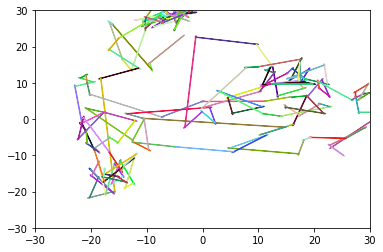

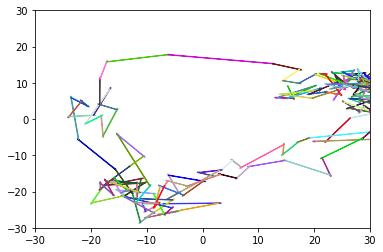

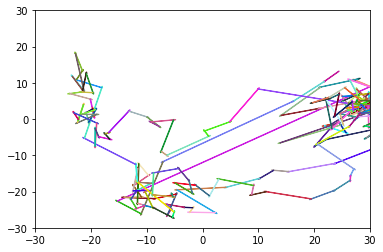

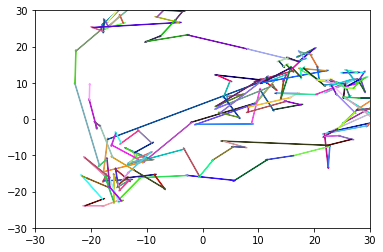

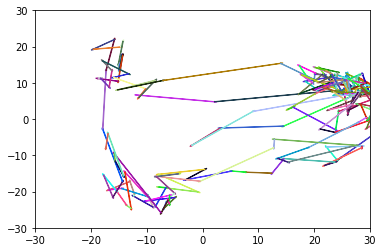

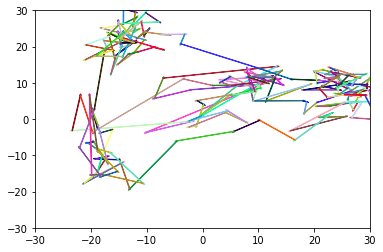

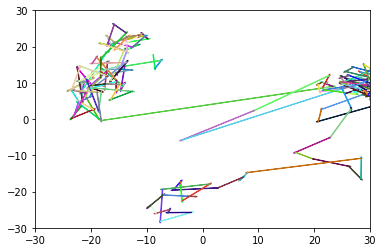

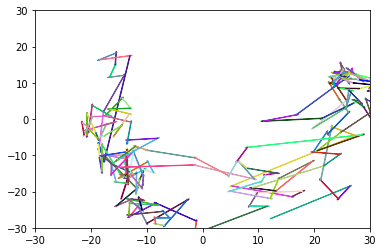

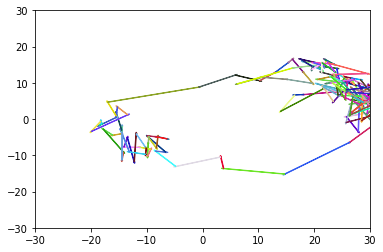

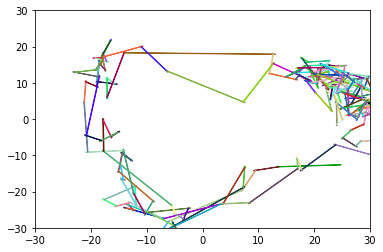

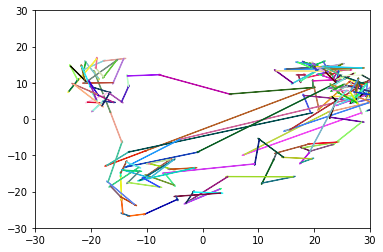

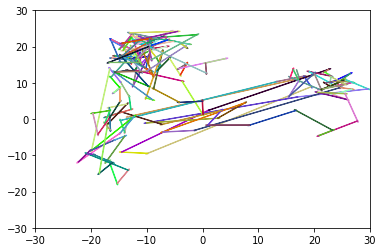

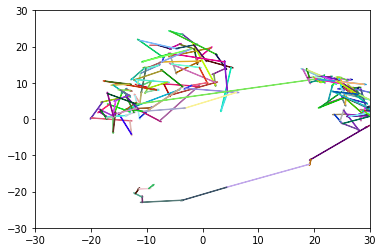

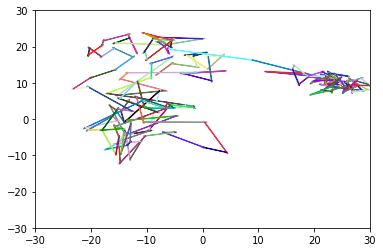

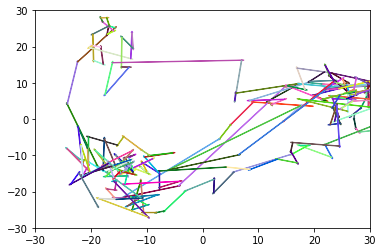

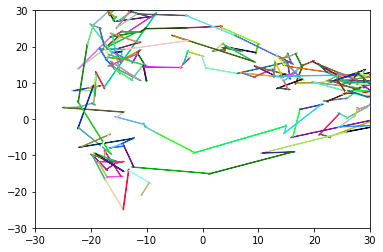

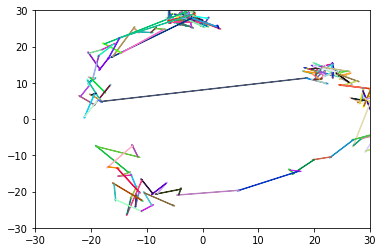

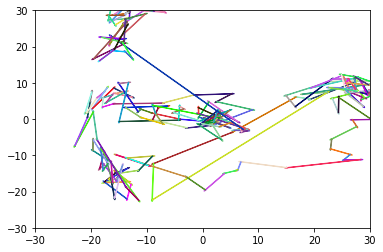

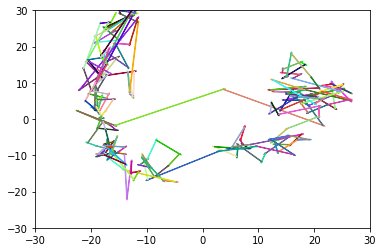

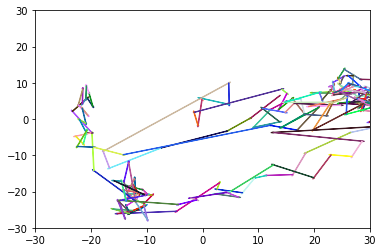

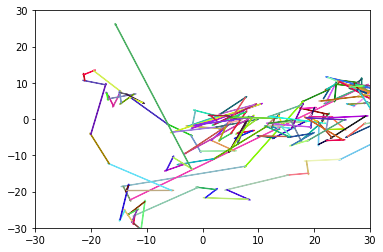

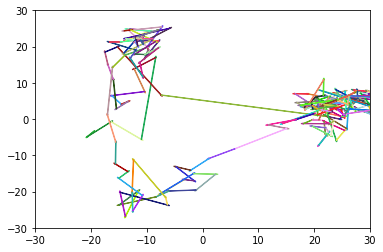

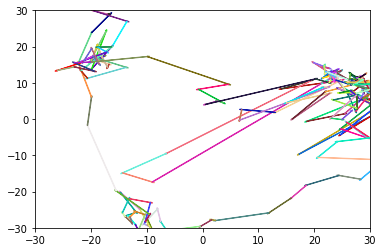

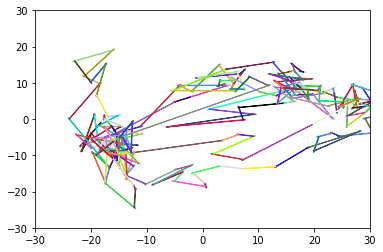

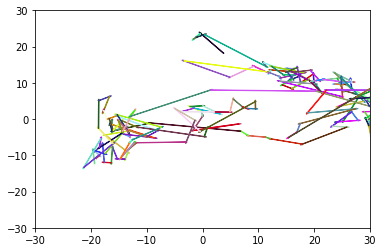

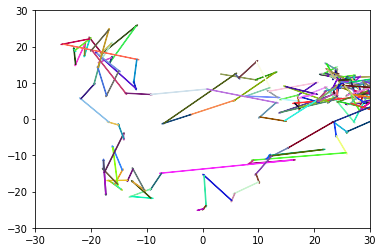

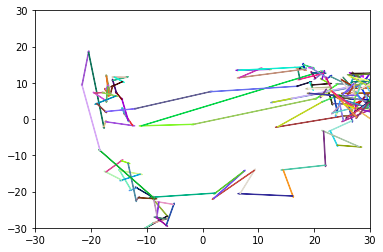

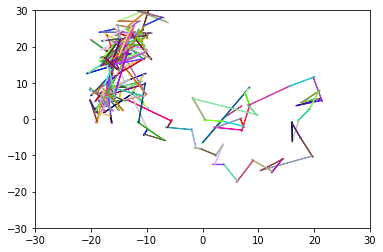

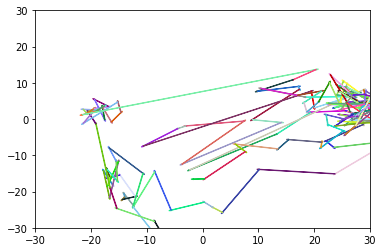

In [99]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
for dc in range(0,xs.__len__()):
    i =0
    dim0 = 0
    dim1 = 1
    #dc = 2
   
    
    if xs[dc].__len__() >150:
        fig = plt.figure()
        plt.ylim(-30,30)
        plt.xlim(-30,30)
        #ax  = Axes3D(fig)


        for xy,clu in zip(xs[dc],cell_data[dc]):
            b = [xy[dim0],xy[dim1]]
           
            if clu == 0:
                
                #ax.scatter(b[0], b[1], i,marker='o',color='c')
                #plt.plot(dc,i,'bx')
                #plt.plot(b[0],b[1],'co',alpha=0.2)
                pass
            if clu == 1:
                #ax.scatter(b[0], b[1], i,marker='o',color='b')
                #plt.plot(dc,i,'bo')
                #plt.plot(b[0],b[1],'bo',alpha=0.2)
                pass
            if clu == 2:
                #ax.scatter(b[0], b[1], i,marker='o',color='k')
                #plt.plot(dc,i,'ko')
                #plt.plot(b[0],b[1],'ko',alpha=0.2)
                pass
            if clu == 3:
                # ax.scatter(b[0], b[1], i,marker='o',color='y')
                #plt.plot(dc,i,'yo')
                #plt.plot(b[0],b[1],'yo',alpha=0.2)
                pass
            if i >0:
                rgb = np.array([np.random.random(),np.random.random(),np.random.random()])#(1-(float(i)/float(256)))
                #ax.plot3D([c[0],b[0]], [c[1],b[1]], [i-1,i], color=rgb )# Data for three-dimensional scattered points

                
                #if np.sqrt((b[0]-c[0])**2+ (b[1]-c[1])**2) <20:
                plt.arrow(c[0],c[1],b[0]-c[0],b[1]-c[1],color=rgb,width=0.1,alpha=1)
            c = b
            i +=1/6


0 255
0 0.0703125


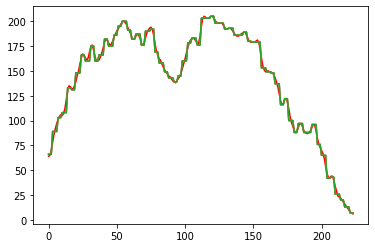

In [44]:
pimg = Image.fromarray(nimg)
rimg = pimg.resize((224, 224))
rimg = np.array(rimg)
plt.plot(rimg[50,:],'r-')
print(np.min(rimg), np.max(rimg))
plt.plot(img[50,:])
print(np.min(nimg), np.max(rgb))


In [ ]:
cell_data[0].__len__()

In [67]:
i

0

In [ ]:
xs[0].__len__()

In [ ]:
(b/cell_data[0].__len__())